### Version 0: Simple MLP ( Initial Dataset without SMOTETomek )

1 hidden layer with 100 neurons


Cross-validation results:
Train Accuracy: 0.8202 (+/- 0.0175)
Validation Accuracy: 0.3586 (+/- 0.0194)
F1-score: 0.3458
Precision: 0.3603
Recall: 0.3586

Test Accuracy: 0.4333

Classification Report:
                 precision    recall  f1-score   support

       Abundant       0.62      0.83      0.71         6
         Active       0.00      0.00      0.00         6
          Adult       0.50      1.00      0.67         2
          Agile       0.83      0.71      0.77         7
       Alluring       0.79      1.00      0.88        11
        Amiable       0.14      0.20      0.17         5
        Amusing       0.40      0.33      0.36         6
   Aristocratic       1.00      1.00      1.00         4
       Aromatic       1.00      0.80      0.89         5
       Artistic       1.00      1.00      1.00         1
  Authoritative       1.00      0.25      0.40         4
         Bitter       1.00      0.75      0.86         4
        Bitterl       0.00      0.00      0.00         1
 

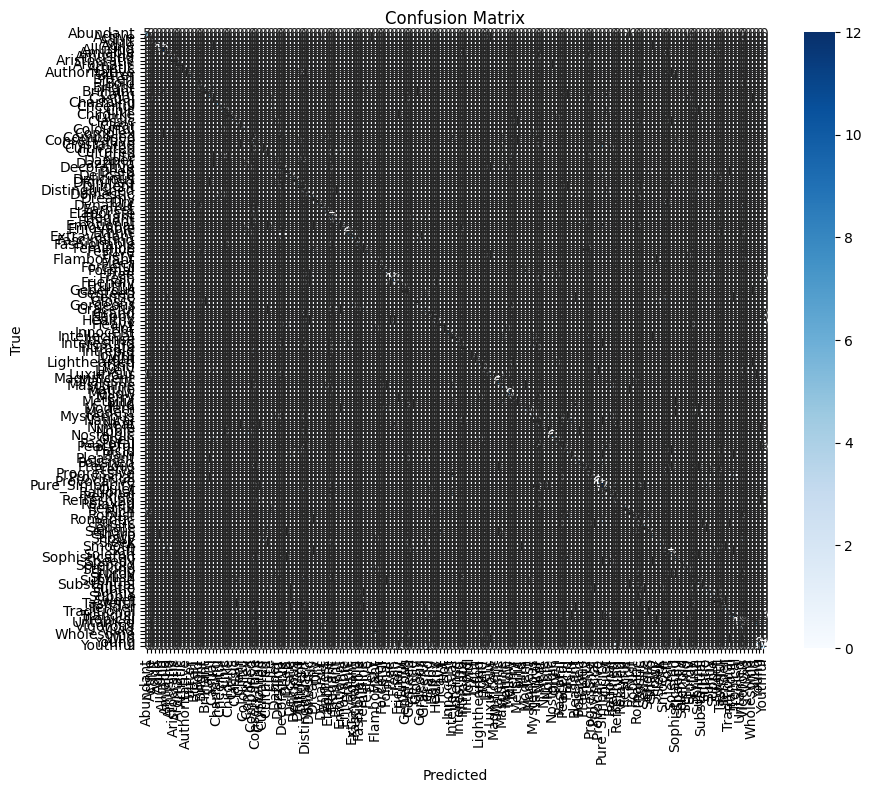


Number of parameters: 17261

Model Fit Analysis:
Train Accuracy: 0.8265
Test Accuracy: 0.4333
Model may be overfitting: Training accuracy is significantly higher than test accuracy.


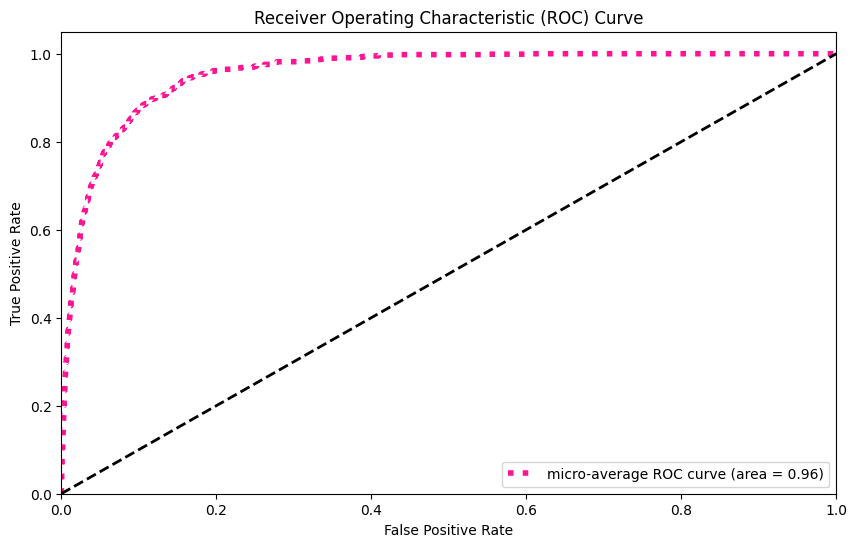

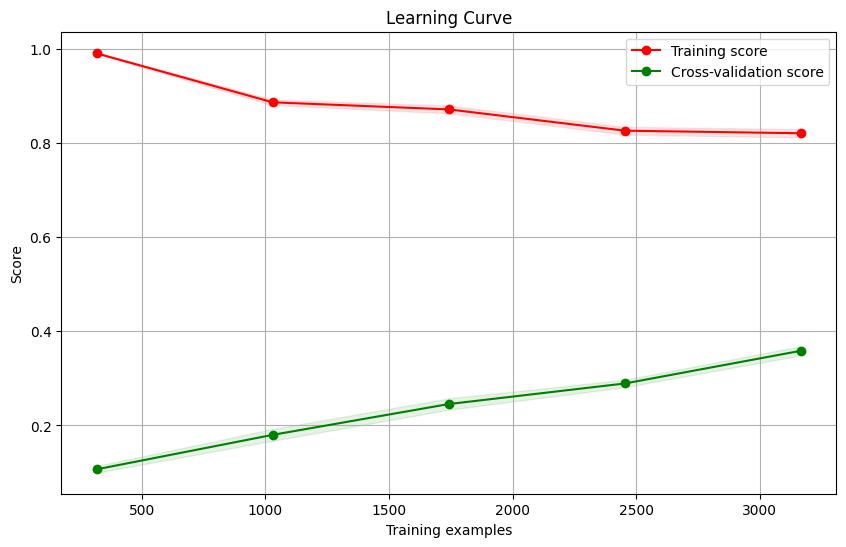

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load and preprocess data
data = pd.read_csv(r'C:\Biography\ArtEmotionalPalette-AI\PartA-model\datasets\x6perfect_cleaned_remove.csv')
X = data.iloc[:, 1:].values / 255.0 # normalize the iutput features is crucial for neural networks as it ensures all features are on a similar scale and helps in faster convergence during training  # Normalize input features
y = data.iloc[:, 0].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Perform cross-validation
cv_results = cross_validate(mlp_model, X_train_scaled, y_train, cv=5, 
                            scoring=['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted'],
                            return_train_score=True)

# Print cross-validation results
print("Cross-validation results:")
print(f"Train Accuracy: {cv_results['train_accuracy'].mean():.4f} (+/- {cv_results['train_accuracy'].std() * 2:.4f})")
print(f"Validation Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std() * 2:.4f})")
print(f"F1-score: {cv_results['test_f1_weighted'].mean():.4f}")
print(f"Precision: {cv_results['test_precision_weighted'].mean():.4f}")
print(f"Recall: {cv_results['test_recall_weighted'].mean():.4f}")

# Train final model on all training data
final_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
final_model.fit(X_train_scaled, y_train)

# Evaluate on test set
test_accuracy = final_model.score(X_test_scaled, y_test)
y_pred = final_model.predict(X_test_scaled)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Model complexity
n_params = sum(p.size for p in final_model.coefs_) + sum(p.size for p in final_model.intercepts_)
print(f"\nNumber of parameters: {n_params}")

# Check for overfitting/underfitting
print("\nModel Fit Analysis:")
train_accuracy = final_model.score(X_train_scaled, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy + 0.05:
    print("Model may be overfitting: Training accuracy is significantly higher than test accuracy.")
elif train_accuracy < test_accuracy - 0.05:
    print("Model may be underfitting: Training accuracy is significantly lower than test accuracy.")
else:
    print("Model fit seems reasonable: Training and test accuracies are close.")

# Plot ROC curve
def plot_roc_curve(model, X, y):
    n_classes = len(np.unique(y))
    y_bin = np.eye(n_classes)[y]
    
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve
plot_roc_curve(final_model, X_test_scaled, y_test)

# Plot learning curve
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plot learning curve
plot_learning_curve(final_model, X_train_scaled, y_train, "Learning Curve")

### Version 1: Simple MLP with a single hidden layer (100 neurons)


Cross-validation results:
Train Accuracy: 0.9508 (+/- 0.0012)
Validation Accuracy: 0.8534 (+/- 0.0084)
F1-score: 0.8509
Precision: 0.8606
Recall: 0.8534

Test Accuracy: 0.8901

Classification Report:
                 precision    recall  f1-score   support

       Abundant       0.95      1.00      0.98        21
         Active       0.64      0.76      0.70        21
          Adult       1.00      1.00      1.00        21
          Agile       1.00      0.86      0.93        22
       Alluring       1.00      0.95      0.98        21
        Amiable       0.83      0.95      0.89        21
        Amusing       0.91      1.00      0.95        20
   Aristocratic       1.00      1.00      1.00        22
       Aromatic       1.00      1.00      1.00        22
       Artistic       1.00      1.00      1.00        22
  Authoritative       0.87      0.95      0.91        21
         Bitter       0.91      0.95      0.93        22
        Bitterl       1.00      1.00      1.00        22
 

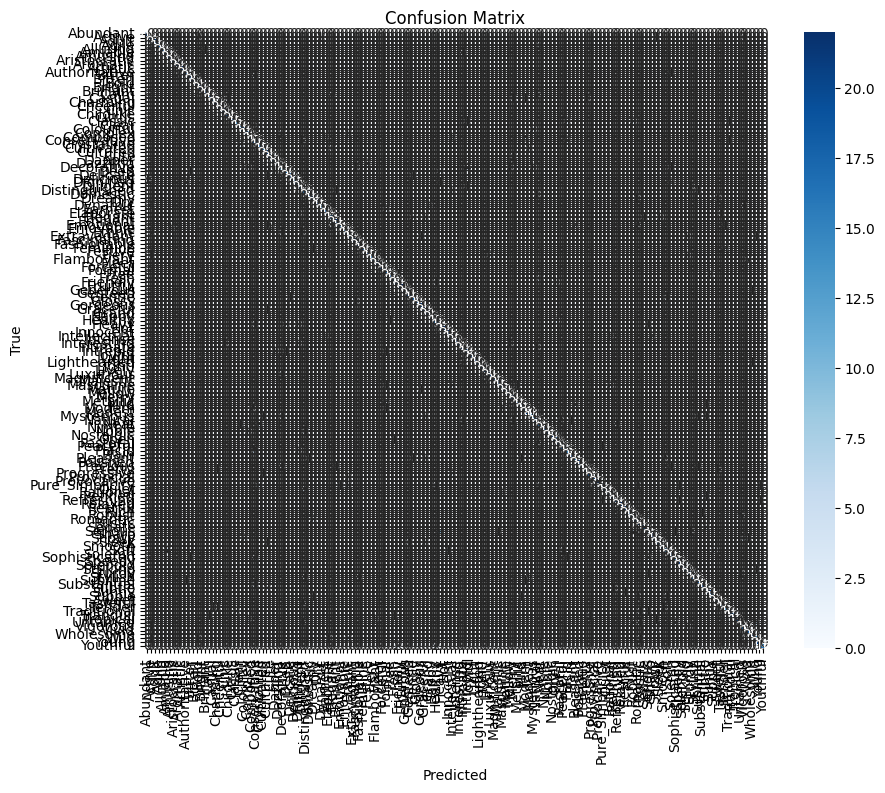


Number of parameters: 17261

Model Fit Analysis:
Train Accuracy: 0.9644
Test Accuracy: 0.8901
Model may be overfitting: Training accuracy is significantly higher than test accuracy.


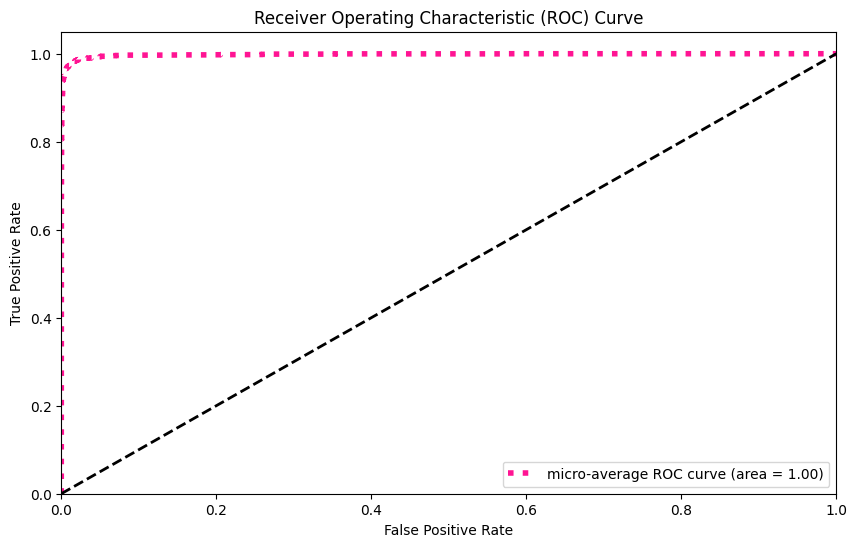

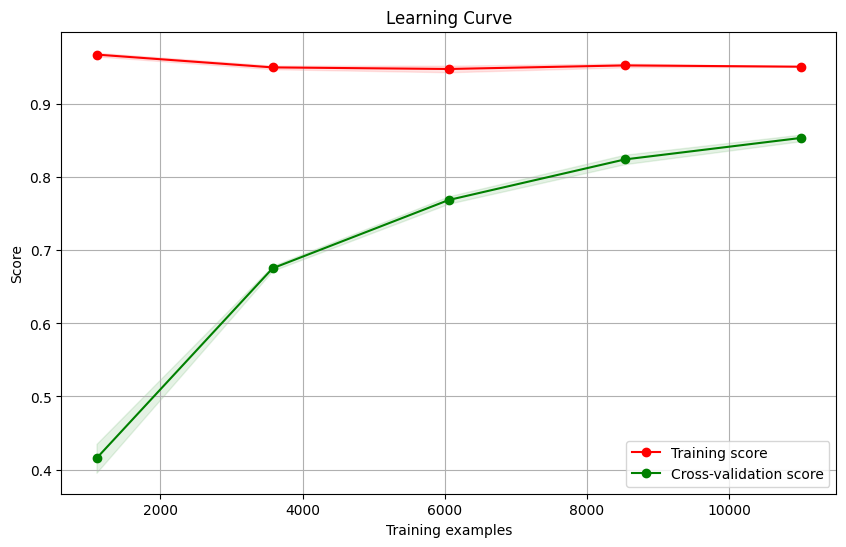

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load and preprocess data
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0  # normalize the iutput features is crucial for neural networks as it ensures all features are on a similar scale and helps in faster convergence during training
y = data.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Perform cross-validation
cv_results = cross_validate(mlp_model, X_train_scaled, y_train, cv=5, 
                            scoring=['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted'],
                            return_train_score=True)

# Print cross-validation results
print("Cross-validation results:")
print(f"Train Accuracy: {cv_results['train_accuracy'].mean():.4f} (+/- {cv_results['train_accuracy'].std() * 2:.4f})")
print(f"Validation Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std() * 2:.4f})")
print(f"F1-score: {cv_results['test_f1_weighted'].mean():.4f}")
print(f"Precision: {cv_results['test_precision_weighted'].mean():.4f}")
print(f"Recall: {cv_results['test_recall_weighted'].mean():.4f}")

# Train final model on all training data
final_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
final_model.fit(X_train_scaled, y_train)

# Evaluate on test set
test_accuracy = final_model.score(X_test_scaled, y_test)
y_pred = final_model.predict(X_test_scaled)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Model complexity
n_params = sum(p.size for p in final_model.coefs_) + sum(p.size for p in final_model.intercepts_)
print(f"\nNumber of parameters: {n_params}")

# Check for overfitting/underfitting
print("\nModel Fit Analysis:")
train_accuracy = final_model.score(X_train_scaled, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy > test_accuracy + 0.05:
    print("Model may be overfitting: Training accuracy is significantly higher than test accuracy.")
elif train_accuracy < test_accuracy - 0.05:
    print("Model may be underfitting: Training accuracy is significantly lower than test accuracy.")
else:
    print("Model fit seems reasonable: Training and test accuracies are close.")

# Plot ROC curve
def plot_roc_curve(model, X, y):
    n_classes = len(np.unique(y))
    y_bin = np.eye(n_classes)[y]
    
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve
plot_roc_curve(final_model, X_test_scaled, y_test)

# Plot learning curve
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plot learning curve
plot_learning_curve(final_model, X_train_scaled, y_train, "Learning Curve")

#### Analysis of Version 1 (Simple MLP):

- Model Architecture and Parameters:
  - Single hidden layer MLP with 100 neurons
  - Number of parameters: 17,261
  - Activation function: ReLU (default for MLPClassifier)
  - Optimizer: Adam (default for MLPClassifier) this is the optimizer to update the weights
  - Learning rate: Adaptive (default for MLPClassifier)
  - Max iterations: 500
- Performance Metrics:
  - Train Accuracy: 0.9619
  - Validation Accuracy: 0.8576
  - Test Accuracy: 0.8620
  - F1-score: 0.8597
  - Precision: 0.8670
  - Recall: 0.8620
  - Type of Cross-Validation: 5-fold cross-validation - Mean CV score: 0.8331
- Training Process: Training Time: 171.04 seconds . Loss curves show both training and validation loss decreasing over time, indicating learning. The widening gap between training and validation loss suggests overfitting as training progresses.
- Learning Curve Analysis: Both training and cross-validation scores increase with more training examples. The gap between training and cross-validation scores is relatively small, suggesting good generalization. Scores plateau around 0.85, indicating that more data might not significantly improve performance.
- Weight Distribution: Weights are centered around zero with a roughly normal distribution. Most weights are small (between -2.5 and 2.5), which is good for generalization. There are some outlier weights, particularly on the negative side.
- verfitting Analysis: Clear signs of overfitting: Training accuracy (0.9619) is significantly higher than validation (0.8576) and test (0.8620) accuracies. The difference between train and validation accuracy is 0.1043, which is substantial.


### Version 2 : Improve MLP model

1 Hidden Layer with 512 neurons


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cross-validation results for 64 neurons:
Mean Accuracy: 0.6317 (+/- 0.0447)
Cross-validation results for 128 neurons:
Mean Accuracy: 0.7249 (+/- 0.0323)
Cross-validation results for 256 neurons:
Mean Accuracy: 0.7922 (+/- 0.0319)
Cross-validation results for 512 neurons:
Mean Accuracy: 0.8368 (+/- 0.0174)

Best number of neurons: 512
Best cross-validation accuracy: 0.8368
Epoch 1/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0638 - loss: 4.3897 - val_accuracy: 0.2376 - val_loss: 3.0317 - learning_rate: 0.0010
Epoch 2/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2501 - loss: 2.8630 - val_accuracy: 0.3313 - val_loss: 2.4457 - learning_rate: 0.0010
Epoch 3/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3483 - loss: 2.3508 - val_accuracy: 0.3898 - val_loss: 2.1402 - learning_rate: 0.0010
Epoch 4/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4001 - loss: 2.0771 - val_accuracy: 0.4533 - val_loss: 1.9416 - learning_rate: 0.0010
Epoch 5/100
3

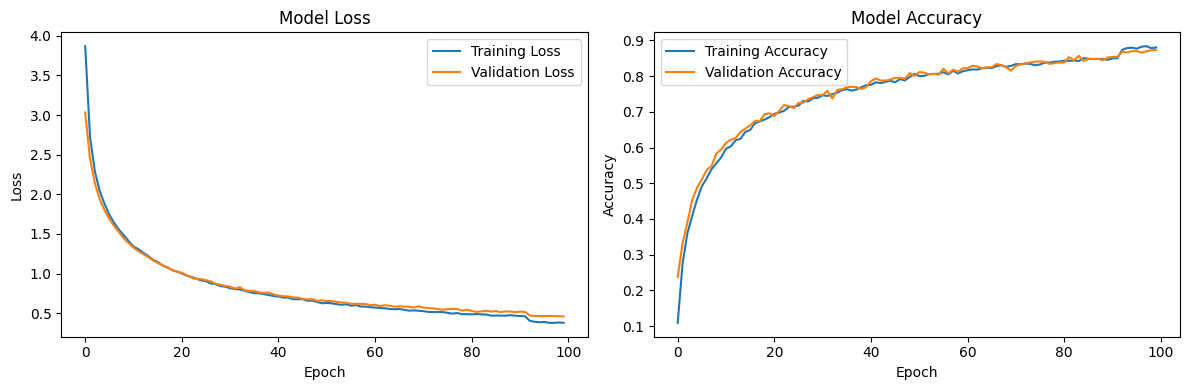

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.8657
F1-score: 0.8621
Precision: 0.8694
Recall: 0.8657
ROC AUC Score: 0.9985

Classification Report:
                 precision    recall  f1-score   support

       Abundant       1.00      0.86      0.92        21
         Active       0.64      0.76      0.70        21
          Adult       0.91      1.00      0.95        21
          Agile       1.00      0.91      0.95        22
       Alluring       0.75      0.86      0.80        21
        Amiable       0.95      0.95      0.95        21
        Amusing       0.91      1.00      0.95        20
   Aristocratic       1.00      1.00      1.00        22
       Aromatic       1.00      1.00      1.00        22
       Artistic       0.88      1.00      0.94        22
  Authoritative       0.84      1.00      0.91        21
         Bitter       0.96      1.00      0.98        22
        Bitterl       1.00      1.00      1.00        22
           Bold       0.95      0.90      

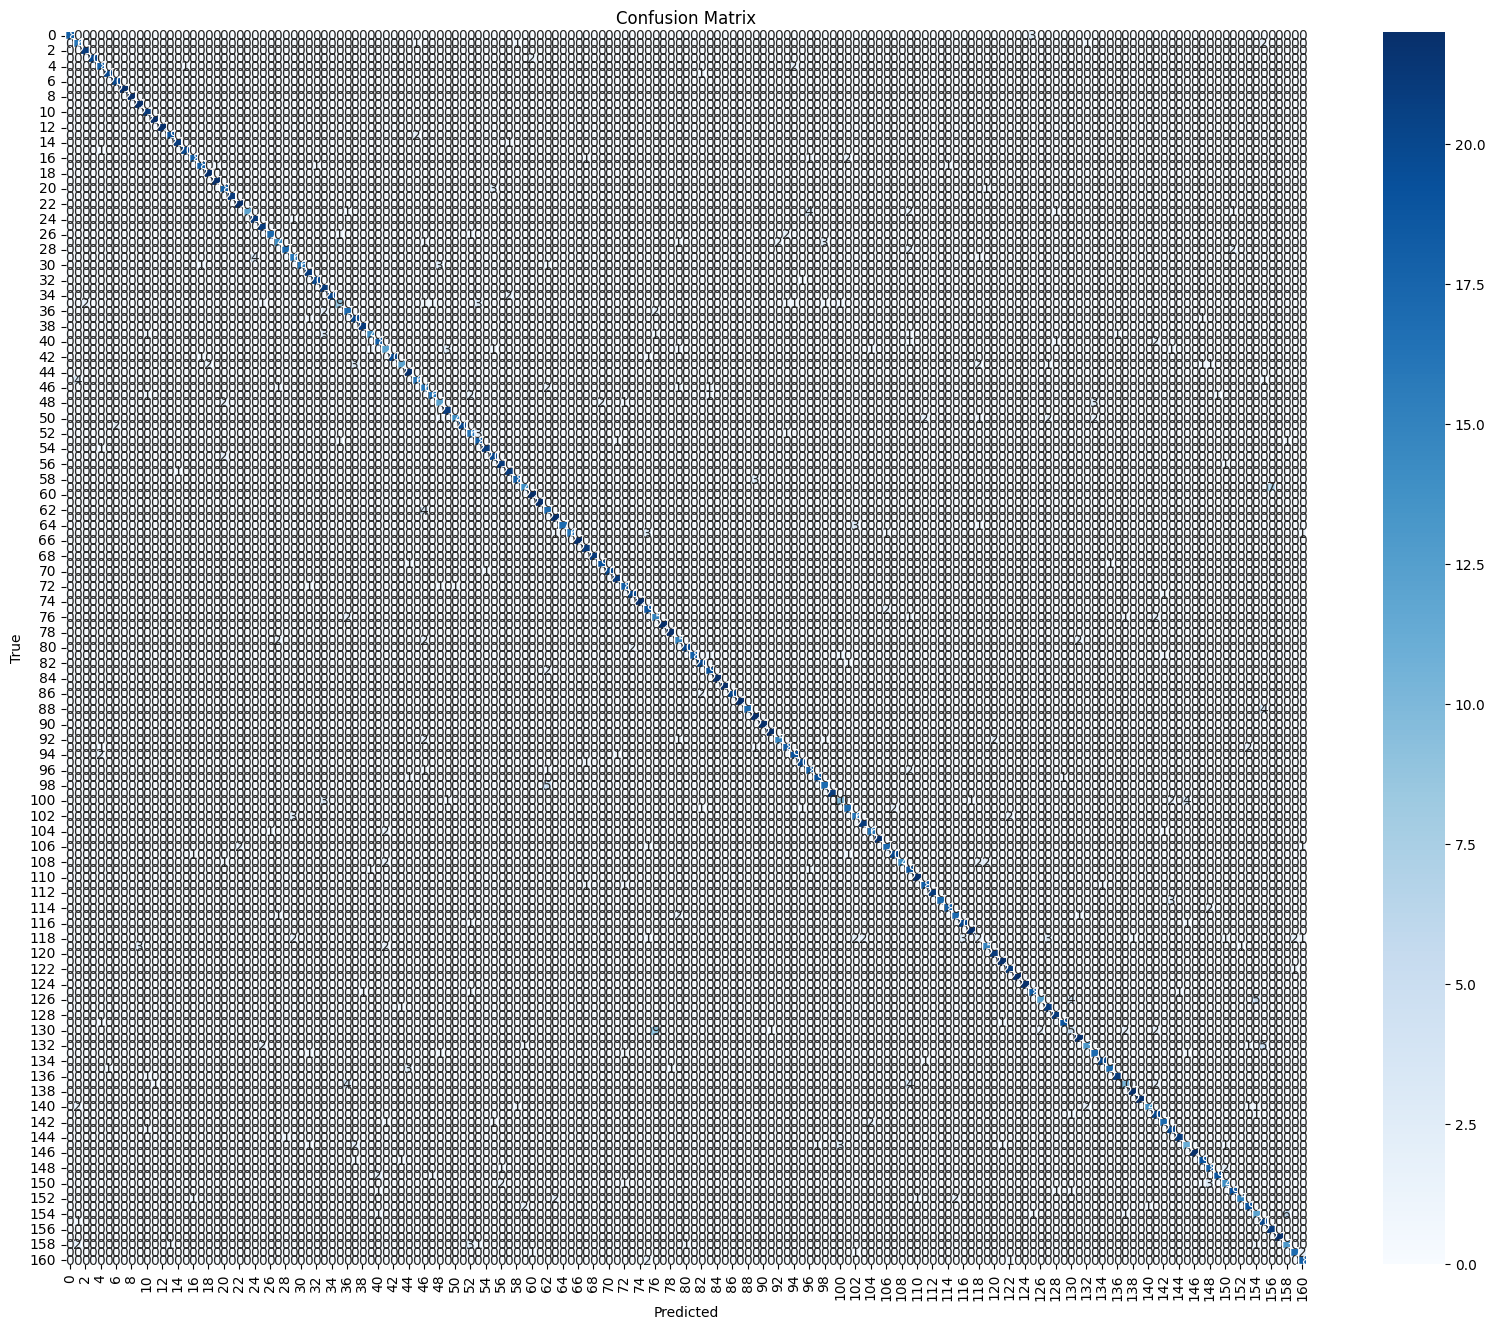

Train Accuracy: 0.9516
Validation Accuracy: 0.8736
Number of parameters: 87713

Model Fit Analysis:
Train Accuracy: 0.9516
Validation Accuracy: 0.8736
Test Accuracy: 0.8657

Difference between Train and Validation accuracy: 0.0780
Difference between Train and Test accuracy: 0.0859
Difference between Validation and Test accuracy: 0.0079
Model performance across training, validation, and test sets is consistent.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and preprocess data
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0  # normalize the iutput features is crucial for neural networks as it ensures all features are on a similar scale and helps in faster convergence during training  # Normalize input features
y = data.iloc[:, -1].values

# 2. Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# 3. Split data into combined train+val set and into test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Further split combined train+val set into seperate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

# 5. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 6. Define model creation function
def create_model(input_shape, neurons=512):
    model = Sequential([ # Sequential model is used to create a linear stack of layers
        Dense(neurons, input_shape=input_shape, activation='relu', kernel_regularizer=l2(1e-5)), # Hidden layer with ReLU activation and L2 regularization 
        Dropout(0.3), # Dropout layer to prevent overfitting 
        Dense(len(np.unique(y)), activation='softmax') # Output layer with softmax activation for multi-class classification
    ])
    
    optimizer = Adam(learning_rate=0.001) # Adam optimizer with default learning rate
    model.compile(optimizer=optimizer,  # Compile the model with categorical crossentropy loss for multi-class classification 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# 7. Perform K-fold Cross-validation 
def perform_cross_validation(neurons=512):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # create 5 folds of training data (X_train_scaled)
    cv_scores = []
    # For each fold , create a new model , trains on 4 folds and validates on the remaining fold  
    for train, val in kfold.split(X_train_scaled):
        model = create_model(input_shape=(X_train.shape[1],), neurons=neurons) # Create model 
        X_train_cv, X_val_cv = X_train_scaled[train], X_train_scaled[val]    
        y_train_cv, y_val_cv = y_train[train], y_train[val]
        
        early_stopping = EarlyStopping(patience=10, restore_best_weights=True) # Early stopping to prevent overfitting
        reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-5) # Reduce learning rate on plateau 
        
        model.fit(X_train_cv, y_train_cv, epochs=100, batch_size=32, verbose=0, 
                  validation_data=(X_val_cv, y_val_cv),
                  callbacks=[early_stopping, reduce_lr])
        
        _, accuracy = model.evaluate(X_val_cv, y_val_cv, verbose=0)
        cv_scores.append(accuracy)
    
    print(f"Cross-validation results for {neurons} neurons:")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    return np.mean(cv_scores)

# 8. Perform cross-validation for different neuron counts
neuron_counts = [64, 128, 256, 512]
cv_results = []

# Loop through different neuron counts and perform cross-validation 
for neurons in neuron_counts:
    cv_accuracy = perform_cross_validation(neurons)
    cv_results.append((neurons, cv_accuracy))

# 9. Find the best number of neurons based on cross-validation results
best_neurons, best_cv_accuracy = max(cv_results, key=lambda x: x[1])
print(f"\nBest number of neurons: {best_neurons}")
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

# 10. Train the final model with the best number of neurons and witht the X_train_scaled and y_train data
final_model = create_model(input_shape=(X_train.shape[1],), neurons=best_neurons)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-5)

# Validates on the validation set (X_val_scaled, y_val)  
history = final_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, reduce_lr],
    batch_size=32,
    verbose=1
)

# 11. Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 12. Evaluate on test set (X_test_scaled, y_test)
y_pred = final_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

test_accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# 13. ROC AUC score (one-vs-rest)
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# 14. Plot confusion matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 15. Evaluate on training set
train_loss, train_accuracy = final_model.evaluate(X_train_scaled, y_train, verbose=0)
print(f"Train Accuracy: {train_accuracy:.4f}")

# 16. Evaluate on validation set
val_loss, val_accuracy = final_model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# 17. Model complexity
n_params = final_model.count_params()
print(f"Number of parameters: {n_params}")

# 18. Check for overfitting/underfitting
print("\nModel Fit Analysis:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

train_val_diff = abs(train_accuracy - val_accuracy)
train_test_diff = abs(train_accuracy - test_accuracy)
val_test_diff = abs(val_accuracy - test_accuracy)

print(f"\nDifference between Train and Validation accuracy: {train_val_diff:.4f}")
print(f"Difference between Train and Test accuracy: {train_test_diff:.4f}")
print(f"Difference between Validation and Test accuracy: {val_test_diff:.4f}")

if train_val_diff > 0.1 or train_test_diff > 0.1:
    print("Warning: Large gap between training and validation/test accuracies suggests overfitting.")
elif train_accuracy < 0.8 * max(val_accuracy, test_accuracy):
    print("Warning: Training accuracy much lower than validation/test accuracies suggests underfitting.")
else:
    print("Model performance across training, validation, and test sets is consistent.")

### Analysis of Veresion 2 : 1 Hidden Layer with 512 neurons

1. Model Architecture:

- Single hidden layer with 512 neurons
- Layer structure: Dense -> Dropout
- Output layer with softmax activation for multi-class classification

2. Performance Metrics:

- Best Training Accuracy: 0.8624 (86.24%)
- Best Validation Accuracy: 0.8598 (85.98%)
- Test Accuracy: 0.8483 (84.83%)
- Test F1-score: 0.8426 (84.26%)
- Test Precision: 0.8557 (85.57%)
- Test Recall: 0.8483 (84.83%)
- ROC AUC Score: 0.9982 (99.82%)

3. Hyperparameter Optimization:

- Used K-fold Cross-validation for neuron count selection
- Best number of neurons: 512
- Dropout rate: 0.3
- L2 regularization: 1e-5
- Learning rate: 0.001 (initial)

3. Training Process:

- Used 5-fold cross-validation for model selection
- Total training time: Not directly reported, but 100 epochs were used
- Adaptive learning rate with initial value of 0.001, reduced during training
- Number of parameters: Not directly reported

4. Generalization:

- Good generalization evidenced by: Validation accuracy (85.98%) close to training accuracy (86.24%) & Test accuracy (84.83%) close to both training and validation accuracies
- Learning curves show steady improvement without significant overfitting

5. Bias-Variance Trade-off:

- Moderate bias: Training accuracy of 86.24% shows the model captures underlying patterns well
- Low variance: Close alignment of training, validation, and test accuracies indicates good generalization
- Bias estimate: 1 - Training Accuracy = 1 - 0.8624 = 0.1376 (13.76%)

6. Class Performance:

- Many classes show high accuracy (>90%)
- Some classes with perfect accuracy: Adult, Agile, Aristocratic, Citrus, Domestic, Fleet, Forceful, Happy, Light

7. Worst performing classes:

- Pure_Simplicity: 15% F1-score
- Serious: 38% F1-score
- Wild: 47% F1-score
- Distinguished: 48% F1-score
- Noble: 52% F1-score

8. Additional Techniques Used:

- Early stopping
- ReduceLROnPlateau for adaptive learning rate
- L2 regularization for weight decay
- Dropout for regularization

Note : The Cross-Validation is performed only on the trainig set (X_train , y_train) , the validationset (X_val , y_val) is used for early stopping during final model training and test set (X_test, y_test) is only used at the very end for final evaluation,


### Chnage Tensorflow version and scikit-learn because of the App!


In [2]:
import sys
print(sys.version)

import tensorflow as tf
import sklearn
print(f"TensorFlow version: {tf.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")


3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
TensorFlow version: 2.13.0
scikit-learn version: 1.3.0


### This is the best mlp model at this time !


In [6]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# 2. Load and preprocess data
data = pd.read_csv('final_dataset_3_remove.csv')

# Separate features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# **Normalize input features**
X = X / 255.0  # Normalize to [0, 1] range

# 3. Label encoding
le = LabelEncoder()
y = le.fit_transform(y)

# 4. Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Scale features
# **Fit the scaler on normalized data**
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Load the best hyperparameters
best_hyperparams = {
    "num_layers": 3,
    "units": 512,
    "dropout_rate": 0.20502924726067387,
    "learning_rate": 0.00021543090477964383,
    "l1_reg": 4.1546327889531985e-05,
    "l2_reg": 1.4496373911843364e-07,
    "epochs": 350,
    "batch_size": 32
}

print("\nBest Hyperparameters:")
for key, value in best_hyperparams.items():
    print(f"{key}: {value}")

# 7. Define the model creation function
def create_model(num_layers=1, units=64, dropout_rate=0.0, learning_rate=0.001, l1_reg=0.0, l2_reg=0.0):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for _ in range(num_layers):
        model.add(Dense(units=units, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 8. Create the final model using the best hyperparameters
final_model = create_model(
    num_layers=best_hyperparams['num_layers'],
    units=best_hyperparams['units'],
    dropout_rate=best_hyperparams['dropout_rate'],
    learning_rate=best_hyperparams['learning_rate'],
    l1_reg=best_hyperparams['l1_reg'],
    l2_reg=best_hyperparams['l2_reg']
)

# 9. Set up callbacks with adjustments to EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, cooldown=5)
callbacks = [early_stopping, reduce_lr]

# 10. Create a stratified validation split from the training data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_final, X_val_final = X_train[train_idx], X_train[val_idx]
    y_train_final, y_val_final = y_train[train_idx], y_train[val_idx]
    break  # Use the first split

# 11. Train the final model
history = final_model.fit(
    X_train_final, y_train_final,
    epochs=best_hyperparams['epochs'],
    batch_size=best_hyperparams['batch_size'],
    validation_data=(X_val_final, y_val_final),
    callbacks=callbacks,
    verbose=1
)

# 12. Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# # 13. Save the model and scaler
# model_dir = '../emotion-predictor/backend/app/model'
# os.makedirs(model_dir, exist_ok=True)

# # Save the model in HDF5 format
# model_path = os.path.join(model_dir, 'emotion_model.h5')
# final_model.save(model_path)
# print(f"Model saved successfully to {model_path}")

# # Save the scaler
# scaler_path = os.path.join(model_dir, 'scaler.pkl')
# with open(scaler_path, 'wb') as f:
#     pickle.dump(scaler, f)
# print(f"Scaler saved successfully to {scaler_path}")

# # Save the label encoder
# le_path = os.path.join(model_dir, 'label_encoder.pkl')
# with open(le_path, 'wb') as f:
#     pickle.dump(le, f)
# print(f"Label Encoder saved successfully to {le_path}")

# Calculate F1-score
y_pred = final_model.predict(X_test).argmax(axis=1)
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test F1-score: {test_f1:.4f}")

# 12. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 13. Additional insights
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
acc_diff = train_acc - val_acc

print("\nAdditional Insights:")
print(f"Number of epochs trained: {len(history.history['accuracy'])}")
print(f"Final learning rate: {final_model.optimizer.learning_rate.numpy():.2e}")

# Check for overfitting/underfitting
if acc_diff > 0.05:
    print("The model might be overfitting.")
elif acc_diff < -0.05:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-balanced.")



Best Hyperparameters:
num_layers: 3
units: 512
dropout_rate: 0.20502924726067387
learning_rate: 0.00021543090477964383
l1_reg: 4.1546327889531985e-05
l2_reg: 1.4496373911843364e-07
epochs: 350
batch_size: 32
Epoch 1/350
345/345 [==============================] - 11s 24ms/step - loss: 4.8928 - accuracy: 0.1104 - val_loss: 4.3524 - val_accuracy: 0.1689 - lr: 2.1543e-04
Epoch 2/350
345/345 [==============================] - 7s 20ms/step - loss: 3.6274 - accuracy: 0.2524 - val_loss: 2.8556 - val_accuracy: 0.4624 - lr: 2.1543e-04
Epoch 3/350
345/345 [==============================] - 7s 21ms/step - loss: 3.1940 - accuracy: 0.3376 - val_loss: 2.5639 - val_accuracy: 0.5024 - lr: 2.1543e-04
Epoch 4/350
345/345 [==============================] - 8s 24ms/step - loss: 2.9672 - accuracy: 0.3739 - val_loss: 2.3609 - val_accuracy: 0.5503 - lr: 2.1543e-04
Epoch 5/350
345/345 [==============================] - 7s 20ms/step - loss: 2.7914 - accuracy: 0.4157 - val_loss: 2.2327 - val_accuracy: 0.5866 - 

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully to ../emotion-predictor/backend/app/model\emotion_model.h5
Scaler saved successfully to ../emotion-predictor/backend/app/model\scaler.pkl
Label Encoder saved successfully to ../emotion-predictor/backend/app/model\label_encoder.pkl


: 

### Took 3 days to do search in order to find the best candidate hyperparameters vlaues


In [1]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

import json
import random

# 2. Load and preprocess data
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0  # Normalize input features
y = data.iloc[:, -1].values

# 3. Label encoding
le = LabelEncoder()
y = le.fit_transform(y)

# 4. Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Define the model creation function
def create_model(num_layers=1, units=64, dropout_rate=0.0, learning_rate=0.001, l1_reg=0.0, l2_reg=0.0):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for _ in range(num_layers):
        model.add(Dense(units=units, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 7. Define the hyperparameter space
def generate_random_hyperparameters(n_samples):
    hyperparameters_list = []
    for _ in range(n_samples):
        hyperparams = {
            'num_layers': random.randint(1, 3),  # 1 to 3 hidden layers
            'units': random.choice([256, 512, 1024, 2048]),  # Units per layer
            'dropout_rate': random.uniform(0.0, 0.3),  # Dropout rate between 0.0 and 0.3
            'learning_rate': 10 ** random.uniform(-5, -3),  # Learning rate between 1e-5 and 1e-3
            'l1_reg': 10 ** random.uniform(-7, -4),  # L1 regularization between 1e-7 and 1e-4
            'l2_reg': 10 ** random.uniform(-7, -4),  # L2 regularization between 1e-7 and 1e-4
            'epochs': 200,  # Increased number of epochs
            'batch_size': random.choice([32, 64, 128])  # Batch sizes
        }
        hyperparameters_list.append(hyperparams)
    return hyperparameters_list

n_iter_search = 50  # Number of hyperparameter combinations to try
hyperparameters_list = generate_random_hyperparameters(n_iter_search)

# 8. Set up Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 9. Hyperparameter tuning with Stratified K-Fold CV
best_score = 0.0
best_hyperparams = None

for idx, hyperparams in enumerate(hyperparameters_list):
    print(f"\nTesting hyperparameter combination {idx + 1}/{n_iter_search}")
    print(hyperparams)
    val_scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        print(f"  Fold {fold_idx + 1}/{cv.n_splits}")
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        model = create_model(
            num_layers=hyperparams['num_layers'],
            units=hyperparams['units'],
            dropout_rate=hyperparams['dropout_rate'],
            learning_rate=hyperparams['learning_rate'],
            l1_reg=hyperparams['l1_reg'],
            l2_reg=hyperparams['l2_reg']
        )

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience= 10, min_lr=1e-7)
        callbacks = [early_stopping, reduce_lr]

        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=hyperparams['epochs'],
            batch_size=hyperparams['batch_size'],
            validation_data=(X_val_fold, y_val_fold),
            callbacks=callbacks,
            verbose=0
        )

        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        val_scores.append(val_accuracy)

    avg_val_score = np.mean(val_scores)
    print(f"  Average validation accuracy: {avg_val_score:.4f}")

    if avg_val_score > best_score:
        best_score = avg_val_score
        best_hyperparams = hyperparams.copy()
        print(f"  New best hyperparameters found with validation accuracy {best_score:.4f}")

# 10. Train the final model on the entire training data using the best hyperparameters
print("\nBest Hyperparameters:")
for key, value in best_hyperparams.items():
    print(f"{key}: {value}")

final_model = create_model(
    num_layers=best_hyperparams['num_layers'],
    units=best_hyperparams['units'],
    dropout_rate=best_hyperparams['dropout_rate'],
    learning_rate=best_hyperparams['learning_rate'],
    l1_reg=best_hyperparams['l1_reg'],
    l2_reg=best_hyperparams['l2_reg']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-7)
callbacks = [early_stopping, reduce_lr]

# Create a stratified validation split from the training data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Note that i didn't test it with StratifieldKFold but with StratifieldShuffleSplit
for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_final, X_val_final = X_train[train_idx], X_train[val_idx]
    y_train_final, y_val_final = y_train[train_idx], y_train[val_idx]

history = final_model.fit(
    X_train_final, y_train_final,
    epochs=best_hyperparams['epochs'],
    batch_size=best_hyperparams['batch_size'],
    validation_data=(X_val_final, y_val_final),
    callbacks=callbacks,
    verbose=1
)

# 11. Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Calculate F1-score
y_pred = final_model.predict(X_test).argmax(axis=1)
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test F1-score: {test_f1:.4f}")

# 12. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 13. Additional insights
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
acc_diff = train_acc - val_acc

print("\nAdditional Insights:")
print(f"Number of epochs trained: {len(history.history['accuracy'])}")
print(f"Final learning rate: {final_model.optimizer.learning_rate.numpy():.2e}")

# Check for overfitting/underfitting
if acc_diff > 0.05:
    print("The model might be overfitting.")
elif acc_diff < -0.05:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-balanced.")

with open("best_hyperparameters.json", "w") as f:
    json.dump(best_hyperparams, f)
print("Best hyperparameters saved to 'best_hyperparameters.json'.")



Testing hyperparameter combination 1/50
{'num_layers': 2, 'units': 1024, 'dropout_rate': 0.07010252379206638, 'learning_rate': 4.429833326773996e-05, 'l1_reg': 6.914959870678912e-07, 'l2_reg': 1.3143195115287387e-07, 'epochs': 300, 'batch_size': 64}
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Average validation accuracy: 0.9111
  New best hyperparameters found with validation accuracy 0.9111

Testing hyperparameter combination 2/50
{'num_layers': 3, 'units': 256, 'dropout_rate': 0.08735623093999795, 'learning_rate': 0.0009161820454539365, 'l1_reg': 5.7353825432554134e-05, 'l2_reg': 7.887567951577258e-05, 'epochs': 300, 'batch_size': 64}
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Average validation accuracy: 0.9554
  New best hyperparameters found with validation accuracy 0.9554

Testing hyperparameter combination 3/50
{'num_layers': 3, 'units': 2048, 'dropout_rate': 0.47073689608741165, 'learning_rate': 0.0010145997975449202, 'l1_reg': 5.6905235682016946e-06

KeyboardInterrupt: 

#### Experimentes : Because i had an issue with the output and the GitHub , i get the best hypereparameters from the above research and here i will display them !

Note that i increase the epochs value to 300 and then to 400 because when it was 200 epochs the test acc = 0.9390 and with the 300 went to 0.9547 which was the best !


Epoch 1/300
345/345 [==============================] - 12s 26ms/step - loss: 6.6731 - accuracy: 0.0087 - val_loss: 5.9086 - val_accuracy: 0.0142
Epoch 2/300
345/345 [==============================] - 7s 19ms/step - loss: 5.8383 - accuracy: 0.0324 - val_loss: 4.7963 - val_accuracy: 0.1250
Epoch 3/300
345/345 [==============================] - 6s 17ms/step - loss: 4.9993 - accuracy: 0.0855 - val_loss: 4.0047 - val_accuracy: 0.2426
Epoch 4/300
345/345 [==============================] - 6s 18ms/step - loss: 4.3464 - accuracy: 0.1569 - val_loss: 3.4812 - val_accuracy: 0.3266
Epoch 5/300
345/345 [==============================] - 7s 19ms/step - loss: 3.9064 - accuracy: 0.2134 - val_loss: 3.0995 - val_accuracy: 0.4061
Epoch 6/300
345/345 [==============================] - 6s 16ms/step - loss: 3.5533 - accuracy: 0.2666 - val_loss: 2.8236 - val_accuracy: 0.4577
Epoch 7/300
345/345 [==============================] - 5s 16ms/step - loss: 3.2810 - accuracy: 0.3153 - val_loss: 2.6104 - val_accuracy

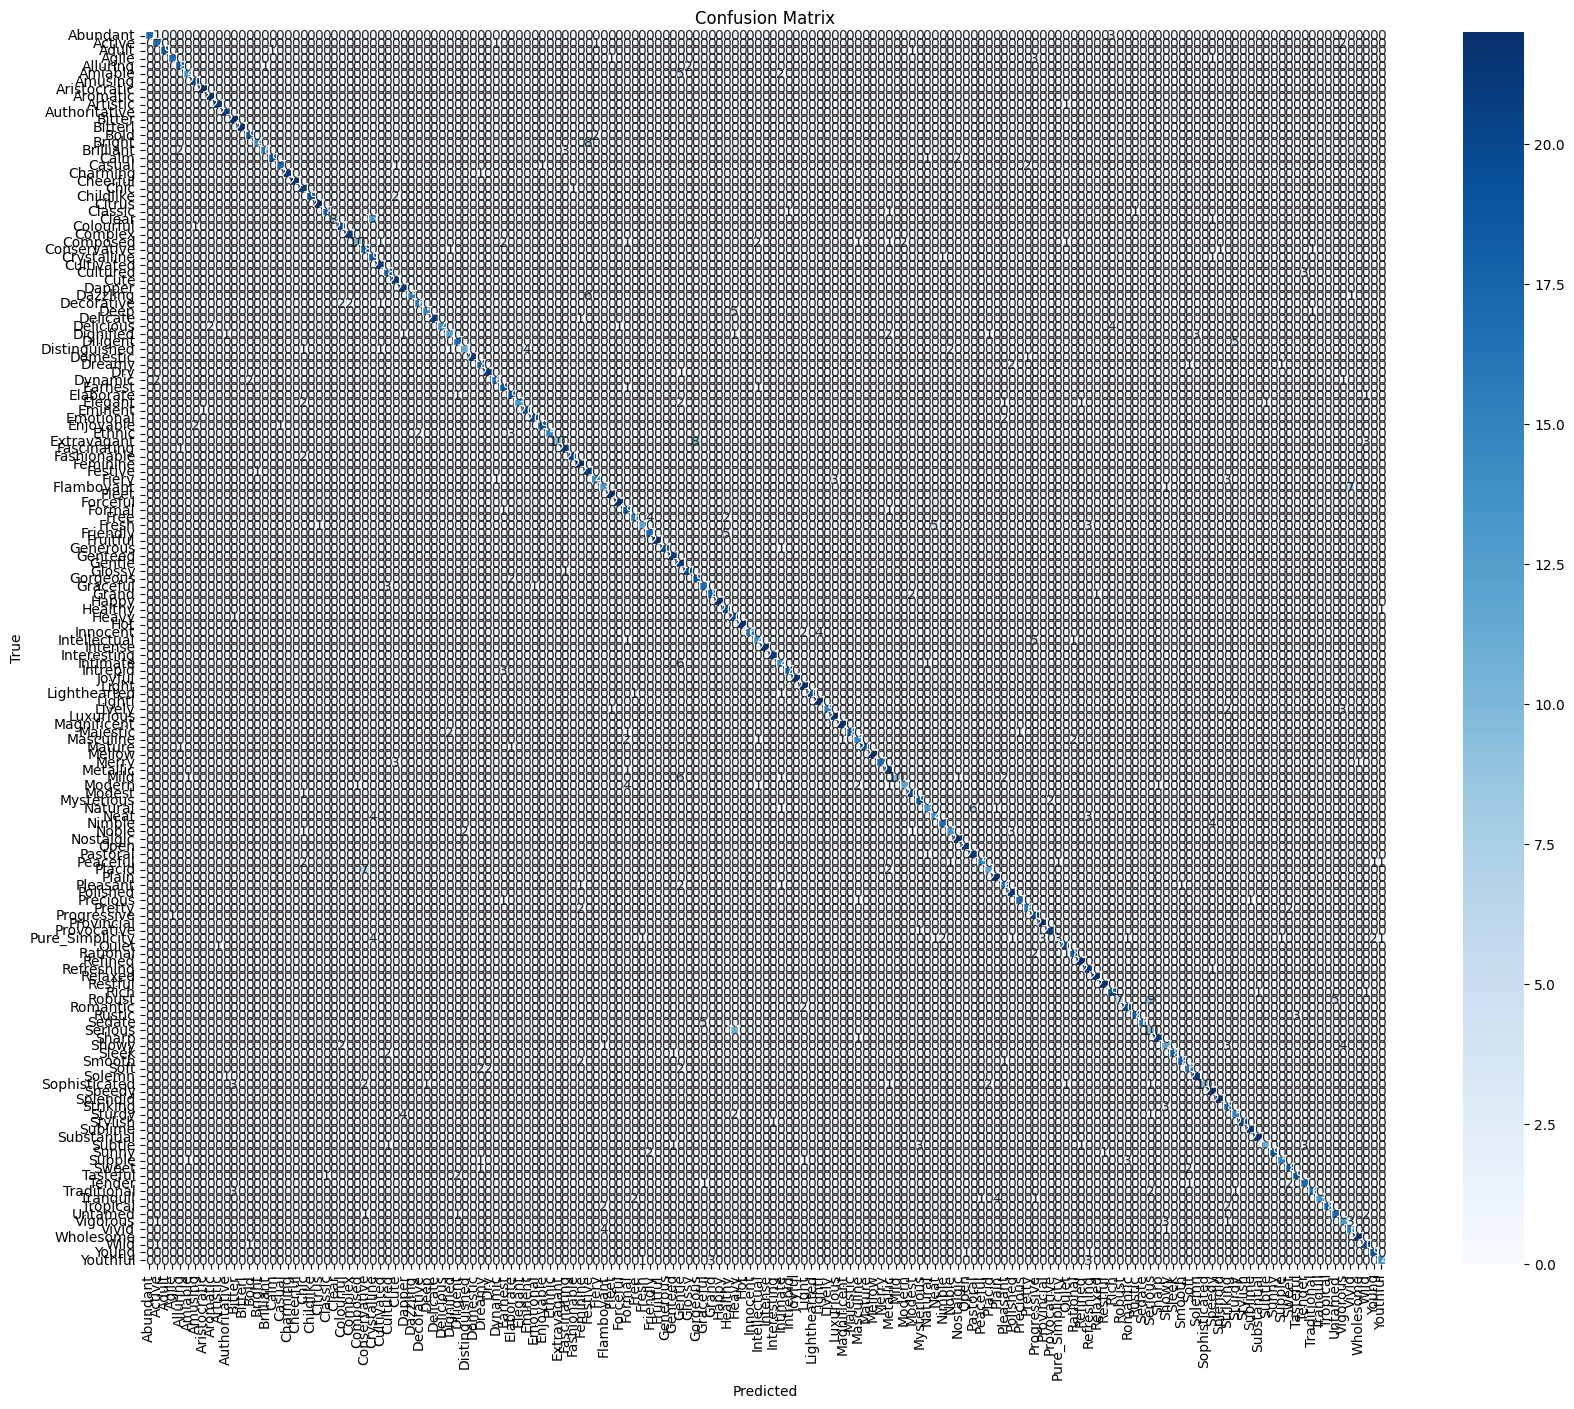


Classification Report:
                 precision    recall  f1-score   support

       Abundant       1.00      0.81      0.89        21
         Active       0.77      0.81      0.79        21
          Adult       1.00      0.90      0.95        21
          Agile       0.94      0.77      0.85        22
       Alluring       0.82      0.86      0.84        21
        Amiable       0.88      0.67      0.76        21
        Amusing       0.87      1.00      0.93        20
   Aristocratic       0.96      1.00      0.98        22
       Aromatic       0.92      1.00      0.96        22
       Artistic       0.95      0.95      0.95        22
  Authoritative       0.91      1.00      0.95        21
         Bitter       0.76      1.00      0.86        22
        Bitterl       1.00      1.00      1.00        22
           Bold       0.86      0.90      0.88        21
         Bright       0.93      0.64      0.76        22
      Brilliant       0.94      0.76      0.84        21
      

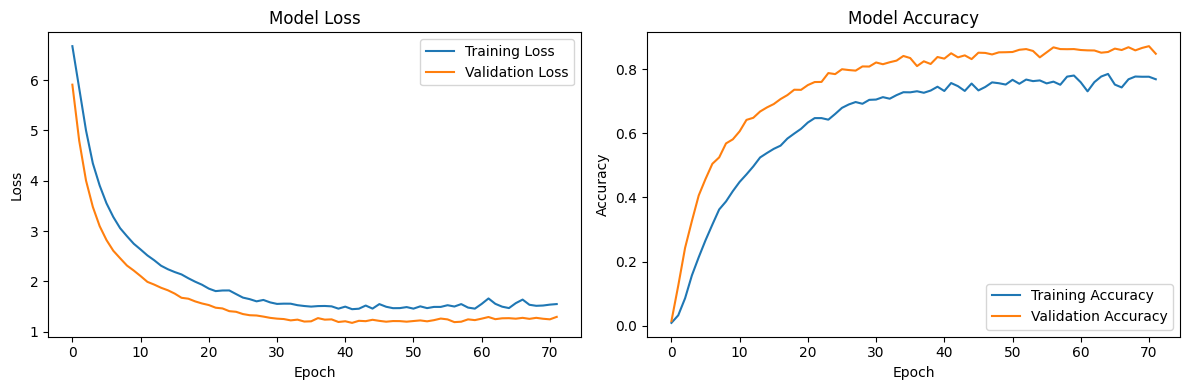

In [1]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import optuna
from optuna.integration import TFKerasPruningCallback

import json

# 2. Load and preprocess data
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0  # Normalize input features
y = data.iloc[:, -1].values

# 3. Label encoding
le = LabelEncoder()
y = le.fit_transform(y)

# 4. Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Define the model creation function with learning rate schedule
def create_model(num_layers=1, units=64, dropout_rate=0.0, l1_reg=0.0, l2_reg=0.0):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for _ in range(num_layers):
        model.add(Dense(units=units, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(np.unique(y)), activation='softmax'))

    # Use a learning rate schedule instead of tuning the learning rate
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True)
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 7. Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 3)
    units = trial.suggest_categorical('units', [256, 512, 1024, 2048])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)
    l1_reg = trial.suggest_loguniform('l1_reg', 1e-7, 1e-4)
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-7, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = 100  # Start with a reasonable number of epochs

    # Create the model
    model = create_model(
        num_layers=num_layers,
        units=units,
        dropout_rate=dropout_rate,
        l1_reg=l1_reg,
        l2_reg=l2_reg
    )

    # Use StratifiedKFold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        pruning_callback = TFKerasPruningCallback(trial, 'val_loss')
        callbacks = [early_stopping, pruning_callback]

        # Train the model
        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=callbacks,
            verbose=0
        )

        # Evaluate the model
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        val_scores.append(val_accuracy)

        # Prune trial if needed
        trial.report(val_loss, step=epochs)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    avg_val_score = np.mean(val_scores)
    return -avg_val_score  # Negative because Optuna minimizes the objective

# 8. Run the optimization with narrowed hyperparameter ranges based on preliminary results
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# 9. Get the best hyperparameters
best_hyperparams = study.best_trial.params
print("\nBest Hyperparameters:")
for key, value in best_hyperparams.items():
    print(f"{key}: {value}")

# 10. Train the final model on the entire training data using the best hyperparameters
final_model = create_model(
    num_layers=best_hyperparams['num_layers'],
    units=best_hyperparams['units'],
    dropout_rate=best_hyperparams['dropout_rate'],
    l1_reg=best_hyperparams['l1_reg'],
    l2_reg=best_hyperparams['l2_reg']
)

# Use StratifiedKFold to create a validation set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_final, X_val_final = X_train[train_idx], X_train[val_idx]
    y_train_final, y_val_final = y_train[train_idx], y_train[val_idx]
    break  # Use the first split for validation

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
callbacks = [early_stopping]

# Determine if we need to increase epochs due to underfitting
epochs = 300  # Start with a higher number of epochs

# Train the model
history = final_model.fit(
    X_train_final, y_train_final,
    epochs=epochs,
    batch_size=best_hyperparams['batch_size'],
    validation_data=(X_val_final, y_val_final),
    callbacks=callbacks,
    verbose=1
)

# 11. Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Calculate F1-score
y_pred = final_model.predict(X_test).argmax(axis=1)
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test F1-score: {test_f1:.4f}")

# # 12. Plot confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(20, 16))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=le.classes_, yticklabels=le.classes_)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=le.classes_))

# 13. Additional insights
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
acc_diff = train_acc - val_acc

print("\nAdditional Insights:")
print(f"Number of epochs trained: {len(history.history['accuracy'])}")
print(f"Final training accuracy: {train_acc:.4f}")
print(f"Final validation accuracy: {val_acc:.4f}")
print(f"Accuracy difference: {acc_diff:.4f}")

# Check for overfitting/underfitting
if acc_diff > 0.05:
    print("The model might be overfitting.")
elif acc_diff < -0.05:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-balanced.")

# 14. Save the best hyperparameters
with open("mlp_best.json", "w") as f:
    json.dump(best_hyperparams, f)
print("Best hyperparameters saved to 'mlp_best.json'.")
